#  Project 3: Web APIs & NLP

## EDA

### The most common words in submissions including stop words

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [33]:
df = pd.read_parquet('./data/cleaned_vectorized_catdog.parquet')
cat_dog = pd.read_csv('./data/cat_dog.csv')

In [34]:
df

,abandon,abandoned,abdomen,abdominal,abed,abide,abiding,abigail,ability,able,...,zig,zigzag,zinc,zip,zombie,zone,zoo,zoom,zoonotic,zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9719,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
cat_dog

,text,subreddit
0,Stepping on toe(bean)s? I know nothing about c...,cats
1,My Cat is a Sock-Thief My (orange) cat does th...,cats
2,It’s belly rubbing time!,cats
3,I have a PSA,cats
4,Our blue eyed devil. He is definitely a sour p...,cats
...,...,...
12957,Most amazing goodest boy I am so so so happy f...,dogs
12958,Are you able to limit her visual access to the...,dogs
12959,Find a second opinion. If it really does come ...,dogs
12960,Absolutely this. My dad when I was a kid was a...,dogs


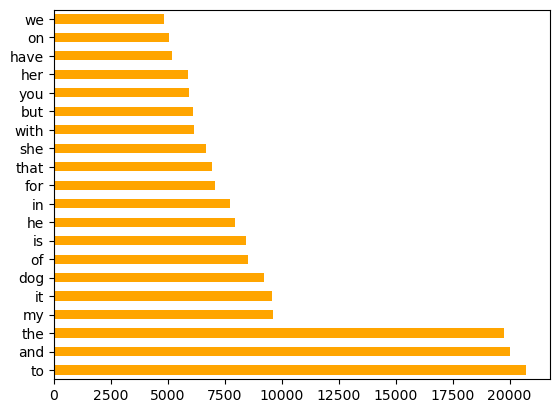

In [36]:
df.sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'orange')
plt.savefig('./most_common_with_stop_words.png', bbox_inches='tight', pad_inches=0.5, transparent=True);

### The most common words in submissions and comments excluding stop words

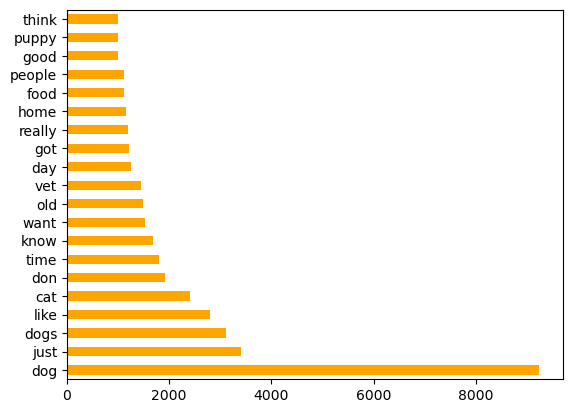

In [37]:
no_stop_words = [word for word in df.columns if word not in CountVectorizer(stop_words = 'english').get_stop_words()]
df[df.columns.intersection(no_stop_words)].sum().sort_values(ascending = False).head(20).plot(
    kind = 'barh',
    color = 'orange')
plt.savefig('./most_common_without_stop_words.png', bbox_inches='tight', pad_inches=0.5, transparent=True);

### The most common brands mentioned on subreddits cats and dogs

In [38]:
# A list of cat and dog food brands
food_brands = ["hill's science diet", 'royal canin', 'purina', 'purina pro plan', 'blue buffalo', 'iams', 'orijen', 'acana',
               'taste of the wild', 'wellness','merrick', 'fromm', 'nutro', "nature's variety", 'canidae', 'natural balance',
               'diamond naturals', 'diamond', 'pedigree', 'eukanuba', 'wellness core', 'nutro ultra', 'mars petcare', 'mars',
               'just food for dogs', 'nestle', 'avoderm', 'advantage ii', 'advantage', 'against the grain', 'alzoo', 'api',
               'fancy feast', 'pedigree', 'meow mix', 'reveal', 'tiny tiger', 'american journey', 'solid gold', 'earthborn holistic',
              'instinct', 'sportmix', 'kitten chow', 'tiki cat', 'tiki', 'applaws', 'authority', 'simply nourish']

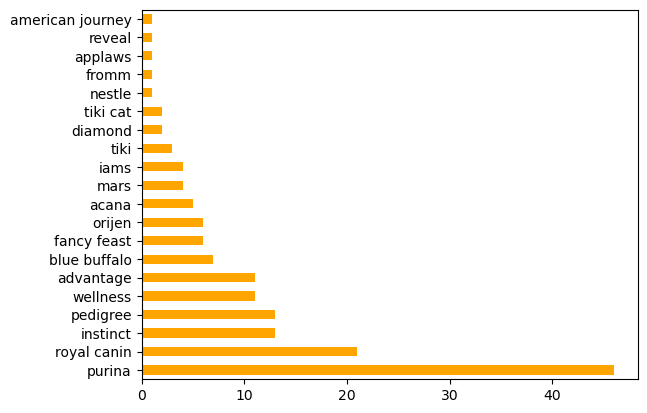

In [39]:
df[df.columns.intersection(food_brands)].sum().sort_values(ascending = False).head(20).plot(kind = 'barh', color = 'orange')
plt.savefig('./brands_counts.png', bbox_inches='tight', pad_inches=0.5, transparent=True);

### Which food brands have been mentioned by users on subreddits?

In [40]:
feature_names = df.columns
brand_columns = [feature for feature in feature_names if feature.lower() in food_brands]
print(f'brands mentioned by users on cat and dog subreddits:\n{brand_columns}')

brands mentioned by users on cat and dog subreddits:
['acana', 'advantage', 'american journey', 'applaws', 'blue buffalo', 'diamond', 'fancy feast', 'fromm', 'iams', 'instinct', 'mars', 'natural balance', 'nestle', 'orijen', 'pedigree', 'purina', 'reveal', 'royal canin', 'solid gold', 'tiki', 'tiki cat', 'wellness']


### Do people have positive or negative opinions about each food brand on cats subreddit?

In [41]:
# A function that normalize text
def normalize_text(text):
    
    tokenizer = RegexpTokenizer(r'\w+')  
    words = tokenizer.tokenize(text.lower())
    
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem words and join them back into a string and deleting stop words
    stemmed_words = [stemmer.stem(word) for word in words if word not in stopwords.words('english')]
    stemmed_text = " ".join(stemmed_words)
    
    return stemmed_text

In [42]:
# A function that Normalize the text with brands name and store them in a list
def text_including_brand(subred, df):
    # Loop through each brand and search for corresponding posts
    brands_text = []
    food_brands = ["hill's science diet", 'royal canin', 'purina', 'purina pro plan', 'blue buffalo', 'iams', 'orijen', 'acana',
               'taste of the wild', 'wellness','merrick', 'fromm', 'nutro', "nature's variety", 'canidae', 'natural balance',
               'diamond naturals', 'diamond', 'pedigree', 'eukanuba', 'wellness core', 'nutro ultra', 'mars petcare', 'mars',
               'just food for dogs', 'nestle', 'avoderm', 'advantage ii', 'advantage', 'against the grain', 'alzoo', 'api',
               'fancy feast', 'pedigree', 'meow mix', 'reveal', 'tiny tiger', 'american journey', 'solid gold', 'earthborn holistic',
              'instinct', 'sportmix', 'kitten chow', 'tiki cat', 'tiki', 'applaws', 'authority', 'simply nourish']
    for brand in food_brands:
        # Define regular expression pattern for brand name
        pattern = re.compile(r'\b' + re.escape(brand) + r'\b', flags=re.IGNORECASE)
        # Loop through each post in dataset and extract text data if brand is mentioned
        for post in df[df['subreddit'] == subred]['text']:
            if re.search(pattern, post):
                brands_text.append(post)
    return brands_text

In [43]:
# Download the Vader lexicon
nltk.download('vader_lexicon')

def sentiment_score(text_list):
    # Load the Vader sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = []
    for text in text_list:
        # Score the sentiment of the text data
        score = analyzer.polarity_scores(text)
        sentiment_scores.append(score)
    return sentiment_scores

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kavia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [44]:
# Functoin that  calculate sentiment score for each brand in a subreddit

from nltk.sentiment.vader import SentimentIntensityAnalyzer

def brand_sentiments(subred, df):
    # Initialize the sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Split the post into sentences
    sentences = nltk.sent_tokenize(''.join(text_including_brand(subred, df)))

    # Extract the sentences that contain each brand name
    brand_sentences = {}
    for brand in food_brands:
        pattern = r'\b{}\b'.format(brand)
        brand_sentences[brand] = [sentence for sentence in sentences if re.search(pattern, sentence)]

    # Perform sentiment analysis on the extracted sentences
    brand_sentiment = {}
    for brand, sentences in brand_sentences.items():
        sentiment_scores = []
        for sentence in sentences:
            sentiment_scores.append(sia.polarity_scores(sentence)['compound'])
        brand_sentiment[brand] = sentiment_scores

    # Aggregate the sentiment scores for each brand
    for brand, sentiment_scores in brand_sentiment.items():
        if len(sentiment_scores) > 0:
            overall_sentiment = sum(sentiment_scores) / len(sentiment_scores)
            print('{}: {:.2f}'.format(brand, overall_sentiment))

In [45]:
# Get the text that includes brands in cat subreddit 
brand_cat = text_including_brand('cats', cat_dog)

# sentiment score for each brand on cats subreddit
brand_sentiments('cats', cat_dog)

diamond: 0.44
mars: -0.44
fancy feast: 0.50
reveal: 0.81
instinct: 0.45
tiki cat: 0.70
tiki: 0.70


In [46]:
# Dataframe of text and its score on cat subreddit
cat_scores_df = pd.DataFrame(sentiment_score(brand_cat))
cat_scores_df['post'] = brand_cat
cat_scores_df = cat_scores_df[['post', 'neg', 'neu', 'pos', 'compound']]
cat_scores_df.head()

,post,neg,neu,pos,compound
0,Very important (kidney disease cats) There has...,0.073,0.805,0.122,0.5948
1,Help my cat’s tummy! My wife and I adopted a s...,0.046,0.890,0.064,0.7309
2,Cat treat probiotics Hello.. Purina are not ma...,0.000,0.748,0.252,0.9378
3,Lower Quality Prescription Food? Background: A...,0.065,0.809,0.126,0.9291
4,They don't always need a specific medication t...,0.000,0.951,0.049,0.6369


### Do people have positive or negative opinions about each food brand on dogs subreddit?

In [18]:
# Get the text that includes brands in dog subreddit 
brand_dog = text_including_brand('dogs', cat_dog)

# sentiment score for each brand on cats subreddit
brand_sentiments('dogs', cat_dog)

royal canin: -0.10
purina: 0.27
purina pro plan: 0.10
blue buffalo: 0.00
orijen: -0.55
acana: -0.32
wellness: 0.19
pedigree: 0.08
advantage: 0.35
reveal: 0.00
instinct: 0.09


In [19]:
# Dataframe of text and its score on dog subreddit
dog_scores_df = pd.DataFrame(sentiment_score(brand_dog))
dog_scores_df['post'] = brand_dog
dog_scores_df = dog_scores_df[['post', 'neg', 'neu', 'pos', 'compound']]
dog_scores_df.head()

,post,neg,neu,pos,compound
0,"Any Frenchie Wizards Here? Hi guys, I have a w...",0.059,0.767,0.175,0.9817
1,Thanks for summoning the food bot! We've had a...,0.051,0.864,0.086,0.9879
2,Struvite/Oxalate Stone Reduction My 7yo Lhasa ...,0.076,0.862,0.062,-0.0772
3,After OCD shoulder surgery as a puppy any adul...,0.000,0.926,0.074,0.8205
4,Need Some Help With Australian Shepherd Food I...,0.024,0.875,0.102,0.9520


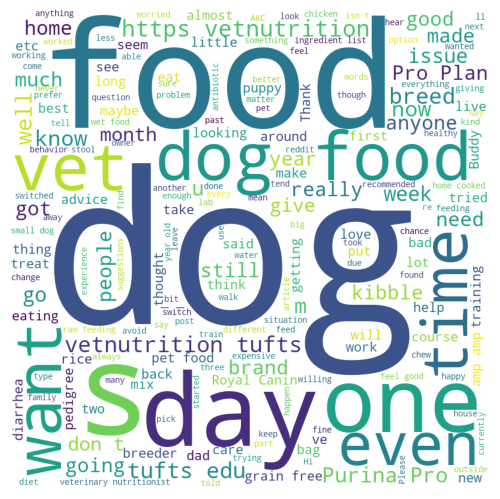

<Figure size 640x480 with 0 Axes>

In [49]:
comment_words = brand_dog

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(''.join(comment_words))
 
# plot the WordCloud image                      
plt.figure( facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()
plt.savefig('./wordcloud.png', bbox_inches='tight', pad_inches=0.5, transparent=True);